# Inverse Schemes for Geodynamic Applications

## Introduction

In this tutorial, we will explore the use of adjoint schemes in geodynamics. Adjoint schemes provide the means for solving inverse problems, allowing us to retrieve unknown parameters or initial conditions in physical systems.

The exercise involves reconstructing the initial temperature field of a single upwelling plume in an enclosed square computational domain. The problem assumes isoviscous, incompressible flow under the Boussinesq approximation, with a Rayleigh number of $Ra=10^6$. This problem is already discussed in `06-GD-2D-convection.ipynb`.

## Setting Up Dependencies

Firstly, let's make sure we have all the dependencies installed. This will set up Firedrake and other required libraries on this Google Colab environment. After doing so, we load `gadopt` and the necessary `gadopt.inverse` which loads the inverse functionalities in gadopt. 

In [1]:
# This magic makes plots appear 
%matplotlib inline
import matplotlib.pyplot as plt

import os
os.environ["GADOPT_LOGLEVEL"] = "WARNING"
#
## Load Firedrake on Colab
#try:
#    import firedrake
#except ImportError:
#    !wget "https://github.com/g-adopt/tutorials/releases/latest/download/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#    import firedrake

from gadopt import *
from gadopt.inverse import *

## Setting Coefficients for Objective Function Terms

In the first section of the script, we define the coefficients for various terms that contribute to the objective function we aim to optimize. These coefficients are:

- $ \alpha_u $: The coefficient for the velocity misfit term, set to $ 1 \times 10^{-1} $.
- $ \alpha_d $: The coefficient for the initial condition damping term, set to $ 1 \times 10^{-2} $.
- $ \alpha_s $: The coefficient for the smoothing term, set to $ 1 \times 10^{-1} $.

These coefficients weight the contributions of each term in the overall objective function, allowing us to fine-tune the optimization problem based on our specific requirements.


In [2]:
alpha_u = 1e-1
alpha_d = 1e-2
alpha_s = 1e-1

### Setting up the Adjoint Tape and Loading the Mesh

1. **Adjoint Tape Setup**: We use `get_working_tape()` to fetch the current working tape and `clear_tape()` to ensure that it is empty. This is crucial for avoiding any conflicts with previous adjoint calculations.




In [3]:
tape = get_working_tape()
tape.clear_tape()

2. **Loading the Mesh**: We load a previously saved mesh from a checkpoint file. The mesh is extruded and contains all the necessary geometric information for our simulation.

In [4]:
with CheckpointFile("mesh.h5", "r") as f:
    mesh = f.load_mesh("firedrake_default_extruded")


3. **Enable Disk Checkpointing**: To manage memory usage efficiently, we enable disk checkpointing. This way, intermediate adjoint fields are written to disk rather than being stored in memory.

In [5]:
enable_disk_checkpointing()

#### Defining Function Spaces and Fields

1. **Function Spaces**: We define various function spaces to hold our solutions. We use Continuous Galerkin (CG) elements for all our function spaces. Specifically, we use second-order elements for the velocity and temperature and first-order elements for the pressure and control.


In [6]:
V = VectorFunctionSpace(mesh, "CG", 2)
W = FunctionSpace(mesh, "CG", 1)
Q = FunctionSpace(mesh, "CG", 2)
Q1 = FunctionSpace(mesh, "CG", 1)
Z = MixedFunctionSpace([V, W])

2. **Fields and Test Functions**: We create a field over the mixed function space `Z` and then split this field into velocity (`u`) and pressure (`p`) subfields. We name them for better identification later on.


In [7]:
z = Function(Z)
u, p = z.subfunctions
u.rename("Velocity")
p.rename("Pressure")

#### Rayleigh Number and Boussinesq Approximation

1. **Rayleigh Number**: We set the Rayleigh number (`Ra`) to $1 \times 10^6$. The Rayleigh number is a dimensionless number that quantifies the driving force for flow due to buoyancy.

2. **Boussinesq Approximation**: We use the Boussinesq approximation for our problem setup. This approximation simplifies the governing equations by neglecting variations in fluid properties, except for density in the buoyancy term.


In [8]:
Ra = Constant(1e6)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

### Defining the Function Spaces

In this section, we define the function spaces that will host our fields. For the velocity field, we use a vector function space `V` with *Continuous Galerkin* (CG) elements of order 2. For the pressure field, we use a scalar function space W with CG elements of order 1. The temperature field resides in another scalar function space `Q` with CG elements of order 2. We also define `Q1`, which is another scalar function space with CG elements of order 1 and will serve as our control space. Finally, `Z` is a mixed function space that combines `V` and `W`.  We also create test functions and function holders for the solutions of our forward problem.

#### Setting up Physical and Numerical Parameters
In this section, we specify the Rayleigh number, $Ra$, which is a critical physical parameter in our simulation. It quantifies the driving buoyancy forces and is set to $10^{6}$. We also initialise the `BoussinesqApproximation` which encapsulates the assumptions we are making about the flow. Furthermore, time-stepping parameters are defined here. We se a constant time step `delta_t` that is set to $4\times10^{-6}$. 

In [9]:
max_timesteps = 80
delta_t = Constant(4e-6)

### Initializing Control and Average Temperature Fields
In the absence of a restart file, our initial guess for the temperature field is the final state of a forward run. To set this up, we project this state from a $Q2$ function space into a $Q1$ function space. This is stored in `Tic`, which is our control variable for the optimization problem. We also project the average temperature profile `Taverage` from the checkpoint file.

In [10]:
Tic = Function(Q1, name="Initial Temperature")
Taverage = Function(Q1, name="Average Temperature")

checkpoint_file = CheckpointFile("Checkpoint_State.h5", "r")
Tic.project(
    checkpoint_file.load_function(mesh, "Temperature", idx=max_timesteps-1)
)
Taverage.project(checkpoint_file.load_function(mesh, "Average Temperature", idx=0))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x155ff20d0>, TensorProductElement(FiniteElement('Lagrange', interval, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), name=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 2)), 13)

## Exercise 
Visualise the 

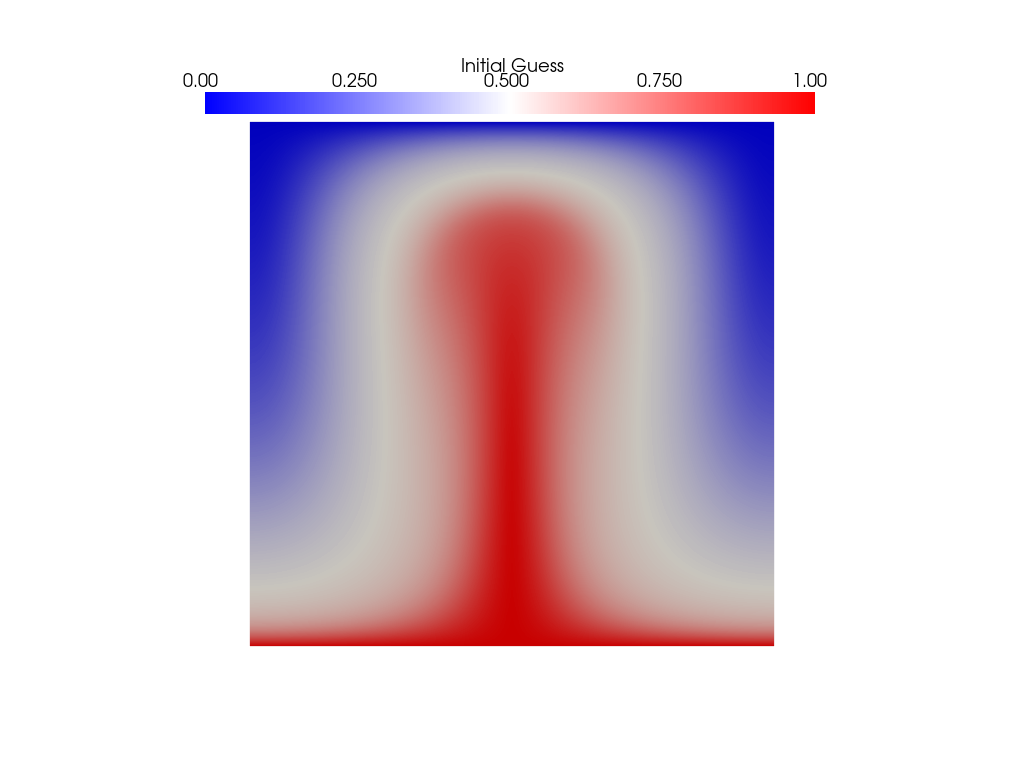

In [33]:
# Let's visualise the final temperature field
File("temp.pvd").write(Tic)
import pyvista as pv
temp_data = pv.read("temp_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data, cmap='bwr', clim=[0, 1],scalar_bar_args={'title': 'Initial Guess', 'position_x': 0.2, 'position_y': 0.85})
plotter.camera_position = "xy"

plotter.show(jupyter_backend="static", interactive=False)


Now that we have initialized our control variable and average temperature profile, we need to define a temperature function `T` in `Q2` space where we'll actually solve the equations. Next, we define the `nullspace` for the Stokes equations using the function `create_stokes_nullspace`. The null-space for the Stokes system consists of a along the z axis, and constant pressure. And finally we define the boundary conditions. 

In [23]:
bottom_id, top_id, left_id, right_id = "bottom", "top", 1, 2
T = Function(Q, name="Temperature")
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)
stokes_bcs = {
    bottom_id: {"uy": 0},
    top_id: {"uy": 0},
    left_id: {"ux": 0},
    right_id: {"ux": 0},
}

temp_bcs = {
    bottom_id: {"T": 1.0},
    top_id: {"T": 0.0},
}

### Initializing the Solvers for Stokes and Energy Equations
In this section, we initialize the solvers for both the Stokes and energy equations. We use the boundary conditions and nullspaces defined earlier. The `StokesSolver` and `EnergySolver` classes take care of the respective equations' discretization and solution.

In [24]:
# Initialize the solver for the Stokes equations
stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
)

# Initialize the solver for the energy equation
energy_solver = EnergySolver(
    T,
    u,
    approximation,
    delta_t,
    ImplicitMidpoint,
    bcs=temp_bcs,
)


### Setting up the Control Variable for Optimization
In this segment, we define the control variable for our optimisation problem. The control variable `Tic` represents the initial temperature and is crucial for the adjoint-based optimization process. The control variable is registered with Pyadjoint using the `Control` class.

We also initialize a variable `u_misfit` to zero. This variable will be used to accumulate the misfit between the observed and simulated velocity fields as the forward model runs.

In [25]:
# Define the control variable for optimization
control = Control(Tic)

# Initialize the variable to accumulate velocity misfit
u_misfit = 0.0

### Projecting the Initial Condition and Running the Forward Simulation
Next, we project the initial condition from the $Q1$ function space to the $Q2$ function space using the project method. We also specify the boundary conditions through `energy_solver.strong_bcs`.

After setting up the initial condition, we run the forward simulation to populate the computational tape for the adjoint calculation. We solve the Stokes and energy equations in each timestep. Additionally, we update the accumulated surface velocity misfit (`u_misfit`) using the checkpointed values from the forward run.


In [26]:
# Project the initial condition and apply boundary conditions
T.project(Tic, bcs=energy_solver.strong_bcs)

# Run the forward simulation
for timestep in range(max_timesteps-10, max_timesteps):
    stokes_solver.solve()
    energy_solver.solve()

    # Update the accumulated surface velocity misfit
    uobs = checkpoint_file.load_function(mesh, name="Velocity", idx=timestep)
    u_misfit += assemble(dot(u - uobs, u - uobs) * ds_t)

#### Loading Observed and Reference States
In this part, we load the observed final temperature state, the reference initial temperature, and the average temperature profile for the simulation domain. These will be used in the objective function.

In [27]:
# Load the observed final state
Tobs = checkpoint_file.load_function(mesh, "Temperature", idx=max_timesteps - 1)
Tobs.rename("Observed Temperature")

# Load the reference initial state
Tic_ref = checkpoint_file.load_function(mesh, "Temperature", idx=0)
Tic_ref.rename("Reference Initial Temperature")

# Load the average temperature profile
Taverage = checkpoint_file.load_function(mesh, "Average Temperature", idx=0)

checkpoint_file.close()

### Defining the Objective Function

Now that we have loaded all the necessary states, we can define the objective function. The objective function consists of multiple terms:

- `t_misfit`: The temperature misfit between the observed and calculated final states.
- `u_misfit`: The velocity misfit term, weighted by $ \alpha_u $.
- `damping`: A damping term for the initial condition, weighted by $ \alpha_d $.
- `smoothing`: A smoothing term, weighted by $ \alpha_s $.

Each of these terms is normalized by various norms calculated earlier. The complete objective function is then given by


$$
\text{objective} = t\_misfit + \alpha_u \left( \frac{{\text{norm\_obs} \times u\_misfit}}{{\text{max\_timesteps} \times \text{norm\_u\_surface}}} \right) + \alpha_d \left( \frac{{\text{norm\_obs} \times \text{damping}}}{{\text{norm\_damping}}} \right) + \alpha_s \left( \frac{{\text{norm\_obs} \times \text{smoothing}}}{{\text{norm\_smoothing}}} \right)$$



In [28]:
# Define the component terms of the overall objective functional
damping = assemble((Tic - Taverage) ** 2 * dx)
norm_damping = assemble(Taverage**2 * dx)
smoothing = assemble(dot(grad(Tic - Taverage), grad(Tic - Taverage)) * dx)
norm_smoothing = assemble(dot(grad(Tobs), grad(Tobs)) * dx)
norm_obs = assemble(Tobs**2 * dx)
norm_u_surface = assemble(dot(uobs, uobs) * ds_t)

# Temperature misfit between solution and observation
t_misfit = assemble((T - Tobs) ** 2 * dx)

objective = (
    t_misfit +
    alpha_u * (norm_obs * u_misfit / max_timesteps / norm_u_surface) +
    alpha_d * (norm_obs * damping / norm_damping) +
    alpha_s * (norm_obs * smoothing / norm_smoothing)
)

### Pausing Annotation and Defining Reduced Functional

In this section, we pause the annotation of operations to the tape. This ensures that only the operations relevant to our problem are included. We then define the reduced functional using the `ReducedFunctional` class provided by pyadjoint. This functional will be minimized in the optimization problem.


In [29]:
# All done with the forward run, stop annotating anything else to the tape
pause_annotation()

# Defining the object for pyadjoint
reduced_functional = ReducedFunctional(objective, control)


### Verification of Gradients: Taylor Remainder Convergence Test

A fundamental tool used in verification of gradients is the Taylor remainder convergence test. For the reduced functional, \( J(T_{IC}) \) and its derivative \(\frac{d J}{d T_{IC}}\), it can be proven that,

$$| J(T_{IC} + h \,\delta T_{IC}) - J(T_{IC}) - h\,\frac{d J}{d T_{IC}} \cdot \delta T_{IC} | \longrightarrow 0 \text{ at } O(h^2).$$

The expression on the left-hand side is termed the second-order Taylor remainder. This term's convergence rate of $O(h^2)$ serves as a strong foundation for verifying any computational implementation meant for determining $\frac{d J}{d T_{IC}}$ (the adjoint code) with respect to a specific functional that computes $J(T_{IC})$ (the forward code). Given any arbitrary selection of $h$ and $\delta T_{IC}$, halving the value of $h$ should decrease the magnitude of the second-order Taylor remainder by a factor of 4. Grounded in this theoretical prediction, we employ these so-called *Taylor tests* to confirm the accuracy of the determined gradients.

To perform a second-order Taylor remainder test, the gradient should be calculated for random perturbations of the initial temperature field $T_{IC}$ and subsequent halving of the amplitude of the perturbations $1/2, 1/4, 1/8 $.

### Exercise 10.1
1. Perform a Taylor test to make sure the derivatives you are calculating are correct. Plot the results against theoretical convergence rate. 
2. Is there anything you can do to stop the Taylor test yielding $O(2.0)$ results?

In [35]:
import numpy as np
Delta_temp = Function(Tic.function_space(), name="Delta_Temperature")
Delta_temp.dat.data[:] = np.random.random(Delta_temp.dat.data.shape)
minconv = taylor_test(reduced_functional, Tic, Delta_temp)


Running Taylor test
Computed residuals: [0.0011112257233898614, 0.00027780641843553076, 6.94516030575688e-05, 1.736290057043835e-05]
Computed convergence rates: [2.000000064457244, 2.0000000322249267, 2.0000000161157554]


<button onclick="javascript:toggle_code()">Show solution</button>
<script>
function toggle_code() {
    var code_cell = Jupyter.notebook.get_selected_index() + 1;
    Jupyter.notebook.get_cells()[code_cell].toggle();
}
</script>

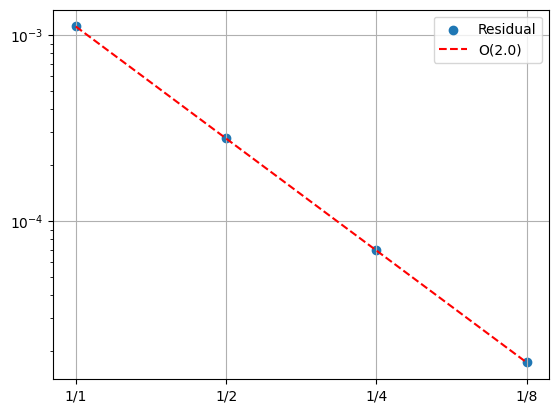

In [73]:
computed_residuals = [0.0011112257233898614, 0.00027780641843553076, 6.94516030575688e-05, 1.736290057043835e-05]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([i for i in range(len(computed_residuals))], computed_residuals, label='Residual')
ax.plot([i for i in range(len(computed_residuals))], [computed_residuals[0]*1/4**(i) for i in range(len(computed_residuals))], color='red', linestyle='--', label='O(2.0)')
ax.set_yscale("log")
ax.set_xticks([i for i in range(len(computed_residuals))])
ax.set_xticklabels([f"1/{2**i}" for i in range(len(computed_residuals))])
ax.legend()
ax.grid()
plt.show()

### Callback Function and Bounded Nonlinear Optimization

In this final section, we define a callback function. This function calculates the initial and final misfits between the optimized and reference initial temperatures, and logs these values. 

We then set up bounds for the temperature control variable, ensuring that it remains in the range $[0, 1]$. 

Lastly, we use the `LinMoreOptimiser` class to perform bounded nonlinear optimization. The callback function is added to the optimizer to be executed at each iteration. 



In [ ]:
def callback():
    initial_misfit = assemble(
        (Tic.block_variable.checkpoint.restore() - Tic_ref) ** 2 * dx
    )
    final_misfit = assemble(
        (T.block_variable.checkpoint.restore() - Tobs) ** 2 * dx
    )

    log(f"Initial misfit; {initial_misfit}; final misfit: {final_misfit}")

# Perform a bounded nonlinear optimisation where temperature
# is only permitted to lie in the range [0, 1]
T_lb = Function(Tic.function_space(), name="Lower bound temperature")
T_ub = Function(Tic.function_space(), name="Upper bound temperature")
T_lb.assign(0.0)
T_ub.assign(1.0)

minimisation_problem = MinimizationProblem(reduced_functional, bounds=(T_lb, T_ub))

optimiser = LinMoreOptimiser(
    minimisation_problem,
    minimisation_parameters,
)
optimiser.add_callback(callback)
optimiser.run()


KeyboardInterrupt: 